In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import pandas as pd

import HERA_hack_FG
import pspec
import make_universe

# import sys
# sys.path.insert(0, '/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/Pipeline')
# import Interferometer_sim

%load_ext autoreload
%autoreload 2


In [191]:
def make_universe(ps,row_npix,col_npix,dim):
    if dim ==2:
    #this box will hold all of the values of k for each pixel
        kbox = np.zeros((row_npix,col_npix))

    #here's the box that will hold the random gaussian things

        fft_box = np.zeros_like(kbox, dtype = complex)
    # kdelta = bins[1]-bins[0]
    #how to i figure out what kdelta is?
    #we're going through the pixels and giving them each a k 
        for i in range(row_npix): 
            for j in range(col_npix): 
                kbox[i,j] = (np.sqrt((i-(row_npix/2))**2 + (j-(col_npix/2))**2)) #there's a kdelta unit missing here which we got from the fftfreq

        for i in range(row_npix):
            for j in range(col_npix): 
                a = float(np.random.normal(0,np.sqrt(ps(kbox[i,j])))) #for discrete, need to interp 
                b = float(np.random.normal(0, np.sqrt(ps(kbox[i,j])))) #for disctrete need to interp
                fft_box[i,j] = complex(a,b)   
    
#         plt.imshow(np.real(fft_box))
#         plt.imshow(np.imag(fft_box))
#         plt.show()
        for i in range(row_npix):
            for j in range(col_npix):
                
                #if our k coordinate is located on the edge of the space, there is no -k equivalent due to even number
                #of pixels. In these cases, we will make sure they are real
                if i <= row_npix/2:
                    mirror_i = (row_npix - i ) % row_npix
                    mirror_j = (col_npix - j ) % col_npix

                    if mirror_i == i and mirror_j == j: 
    
                    # must be real
                        fft_box[i,j] = np.real(fft_box[i,j])
                    else:
                    # copy complex conjugate from mirror coordinates to current coord
                        fft_box[i,j] = np.conjugate(fft_box[mirror_i,mirror_j])
        fft_box[row_npix//2,col_npix//2] = np.real(fft_box[row_npix//2,col_npix//2])
        
        #sns.heatmap(np.imag(fft_box))
    # maybe here I should stack the fft box by column. 
    #should envoke a physical length scale at some point...
        u = np.fft.ifftshift(np.fft.ifftn(np.fft.ifftshift(fft_box)))
        
        universe = (np.real(u))
        
    if dim ==3:
    
    #here's our space which will hold the k values for each pixel
        kbox = np.zeros((npix,npix,npix))

    #here's the box that will hold the random gaussian things

        fft_box = np.zeros_like(kbox, dtype = complex)
    # kdelta = bins[1]-bins[0]
    #how to i figure out what kdelta is?
    #we're going through the pixels and giving them each a k 
        for i in range(npix): 
            for j in range(npix): 
                for h in range(npix):
                    kbox[i,j,h] = (np.sqrt((i-(npix/2))**2 + (j-(npix/2))**2+ (h-(npix/2))**2)) #there's a kdelta unit missing here which we got from the fftfreq

        for i in range(npix):
            for j in range(npix): 
                for h in range(npix):
                    a = float(np.random.normal(0,np.sqrt(ps(kbox[i,j,h]))))
                    b = float(np.random.normal(0, np.sqrt(ps(kbox[i,j,h]))))
                    fft_box[i,j,h] = complex(a,b)   
    
    
        for i in range(npix):
            for j in range(npix):
                for h in range(npix):
                
                #if our k coordinate is located on the edge of the space, there is no -k equivalent due to even number
                #of pixels. In these cases, we will make sure they are real
                    if i <= npix/2:
                        mirror_i = (npix - i ) % npix
                        mirror_j = (npix - j ) % npix
                        mirror_h = (npix - h ) % npix
                        if mirror_i == i and mirror_j == j and mirror_h == h: 
    
                    # must be real
                            fft_box[i,j,h] = np.real(fft_box[i,j,h])
                        else:
                    # copy complex conjugate from mirror coordinates to current coord
                            fft_box[i,j,h] = np.conjugate(fft_box[mirror_i,mirror_j,mirror_h])
        fft_box[npix//2,npix//2] = np.real(fft_box[npix//2,npix//2])
    
        u = np.fft.ifftshift(np.fft.ifftn(np.fft.ifftshift(fft_box)))
        universe = (np.real(u))
        
    
    return universe 

In [3]:
import numpy as np

def make_power_spectrum(data,delta,nbins): 

    dim = len(data.shape)
    
    if dim == 3: 
        fft_data = np.fft.fftn(np.fft.fftshift(data)) 
        ps_data = np.abs(np.fft.fftshift(fft_data))**2 #this has variance equal to p(k)
        
        npix = len(data)
        kx = np.fft.fftfreq(npix,delta)
        ky = np.fft.fftfreq(npix,delta)
        kz = np.fft.fftfreq(npix,delta)
        kdelta = kx[1]-kx[0]

        k = []

        for i in range(len(kx)): 
            for j in range(len(ky)):
                for h in range(len(kz)):
                    k.append(np.sqrt(kx[i]**2 + ky[j]**2 + kz[h]**2))
        
        hist, bin_edges = np.histogram(k, bins = nbins)
        
        a = np.zeros(len(bin_edges)-1) #here you need to take the number of BINS not bin edges!  
                               # you alwaysneed an extra edge than you have bin!

        #c holds, in each element, the number of pixels 
        c = np.zeros_like(a)

        #Here you sum all the pixels in each k bin. 
        for i in range(npix) : 
            for j in range(npix):
                for h in range(npix):
                    kmag = kdelta*np.sqrt((i-npix/2)**2 + (j-npix/2)**2 + (h-npix/2)**2) #need to multiply by kdelta to get your k units
                    for k in range(len(bin_edges)):#make sure that you speed this up by not considering already binned ps's
                        if bin_edges[k] < kmag <= bin_edges[k+1]: 
                            a[k] += ps_data[i,j,h]
                            c[k] += 1
                            break 
                        
        pk = (a/c) /((delta*npix)**2) #take average and divide by area to get P(k)
        kmodes = bin_edges[1:]
        
    elif dim == 2: 
        fft_data = np.fft.fft2(np.fft.fftshift(data))
        ps_data = np.abs(np.fft.fftshift(fft_data))**2
    
        npix = len(data)
        kx = np.fft.fftfreq(npix,delta)
        ky = np.fft.fftfreq(npix,delta)
        kdelta = kx[1]-kx[0]

        k = []

        for i in range(len(kx)): 
            for j in range(len(ky)):
                k.append(np.sqrt(kx[i]**2 + ky[j]**2)) 
            
        hist, bin_edges = np.histogram(k, bins = nbins)
        
        a = np.zeros(len(bin_edges)-1) #here you need to take the number of BINS not bin edges!  
                               # you alwaysneed an extra edge than you have bin!


        c = np.zeros_like(a)

        #Here you sum all the pixels in each k bin. 
        for i in range(npix) : 
            for j in range(npix):
                kmag = kdelta*np.sqrt((i-npix/2)**2 + (j-npix/2)**2) #need to multiply by kdelta to get your k units
                for k in range(len(bin_edges)): #make sure that you speed this up by not considering already binned ps's
                    if bin_edges[k] < kmag <= bin_edges[k+1]: 
                        a[k] += ps_data[i,j]
                        c[k] += 1
                        break
                    
                    
        pk = (a/c) /((delta*npix)**2)
        kmodes = bin_edges[1:]
        
    return kmodes, pk

In [2]:
def ps(x):
    mu, sigma = 0.05,0.007
    return  np.exp( - (x - mu)**2 / (2 * sigma**2))





In [63]:
ps.type

AttributeError: 'function' object has no attribute 'type'

<function matplotlib.pyplot.xlim(*args, **kwargs)>

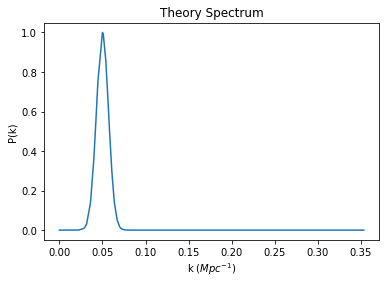

In [3]:
# I have to specify the k scale here. 
make_uni = make_universe.universe(ps,row_npix = 50, col_npix = 50,  Ly = 100,Lx = 100, mean = 0)#100 Mpc by 100Mpc


make_uni.compute_theory_spec()

plt.plot(make_uni.ksorted,make_uni.theory_spec)
plt.title('Theory Spectrum')
plt.xlabel('k ($Mpc^{-1}$)')
plt.ylabel('P(k)')
plt.xlim

In [4]:
print(len(make_uni.ky))
# print(make_uni.kx_pos)
# print(make_uni.kx_neg)
print(make_uni.kx)

50
[-0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19 -0.18 -0.17 -0.16 -0.15 -0.14
 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02
 -0.01  0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1
  0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22
  0.23  0.24]


(50, 50)


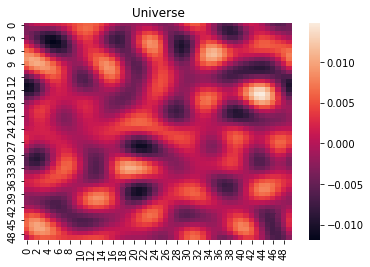

In [5]:

universe = make_uni.make_2D_universe()
print(universe.shape)
ax = plt.axes()
sns.heatmap(universe, ax = ax,)

ax.set_title('Universe')
plt.show()


0.3535533905932738


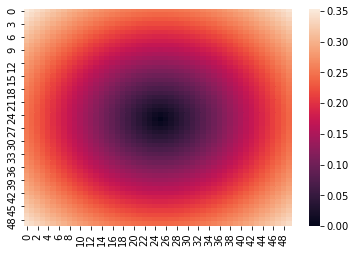

In [6]:
sns.heatmap(make_uni.kbox)

print(max(make_uni.kbox[0]))\
# unfolded = np.reshape(make_uni.kbox,(2500,))
# plt.plot(unfolded)

[  0.   8.   4.  12.  12.  24.   8.  32.  28.  20.  36.  40.  36.  40.
  48.  56.  36.  68.  60.  52.  60.  80.  68.  60.  84.  96.  68.  88.
  88. 112.  64. 120. 100. 100. 116.  86.  84.  68.  56.  48.  48.  44.
  28.  32.  20.  24.  12.  16.   4.   5.]
10000


/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/HERA Hack/pspec.py:162: RuntimeWarning: invalid value encountered in true_divide
  self.pk = (a/c)/volume


Text(0.5, 1.0, 'power spectrum')

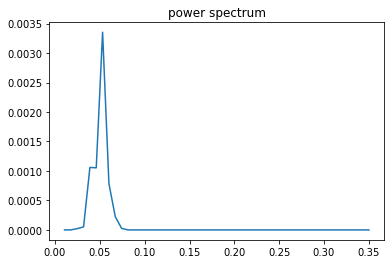

In [7]:
power_spec1 = pspec.Power_Spectrum(data = universe, Lx = 100,Ly = 100, nbins = 50,log = False) #100 Mpc by 100Mpc --> have to scale fft I think 
pk = power_spec1.compute_2D_pspec()
k = pk[0]
p_k = pk[1]

plt.plot(k,p_k) # check about non square
plt.title('power spectrum')


In [8]:
universe_T = universe.T 

stacked_sky = np.hstack(universe.T)


# stacked_sky = np.stack(universe, axis = 1)
# stacked_sky = np.hstack(stacked_sky)

stacked_sky.shape

(2500,)

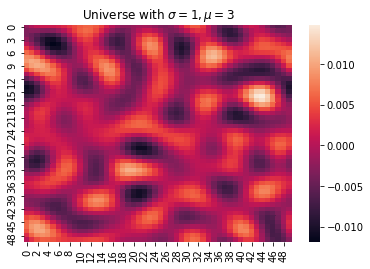

In [9]:
imp = np.reshape(stacked_sky, (50,50))
ax = plt.axes()
sns.heatmap(imp.T, ax = ax,)
ax.set_title('Universe with $\sigma = 1, \mu = 3$')

plt.show()

In [10]:

dishes = np.array([[0,0],[0,55],[30,30],[0,60],[2,55],[47,2],[45,23],[56,21],[30,115],[48,52],[100,100],[0,200],[115,30],[33,31],[49,11],[21,24],[25,6],[56,9],[12,13],[16,17],[38,17],[60,14],[26,28],[6,45],[3,37],[12,55],[200,0],[145,13],[134,65],[139,163]])
data = np.loadtxt('/Users/hannahfronenberg/desktop/MSC1/HERA Noise/hera_positions_staged/antenna_positions_128.dat')
hera_bls = data[:,:-1]

hera_bls_long = []

for i in range(hera_bls.shape[0]):
    mag = np.sqrt(hera_bls[i,0]**2+hera_bls[i,1]**2)
    if mag >= 75:
        hera_bls_long.append(hera_bls[i])
    else:
        continue
        
hera_bls_long = np.asarray(hera_bls_long)[::2]
print(hera_bls_long.shape)

#observable corners of the sky [lat,long]
acorner = np.array([[120,270],[122,280],[1120,280],[122,270]])

HERA = HERA_hack_FG.telescope(hera_bls, latitude=-30, channel_width=0.1, Tsys=300, beam_width=3, beam = 'gaussian')

obs5 = HERA_hack_FG.observation(HERA, 1, 150, 0.01,acorner,1, 0.2, norm = False, pbeam = False)
obs0 = HERA_hack_FG.observation(HERA, 1, 150, 0.01,acorner,1, 0.2, norm = False, pbeam = False)
obs = HERA_hack_FG.observation(HERA, 1, 150, 0.01,acorner,1, 0.2, norm = False, pbeam = True)





(29, 2)


In [11]:
print(obs.sky_shape())
print(obs.Npix)

(30, 50)
1500


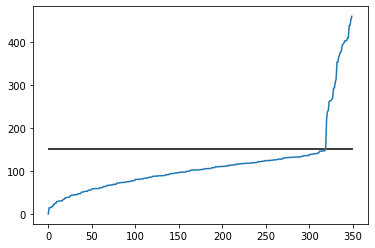

In [88]:
plt.plot(np.sort(np.sqrt(hera_bls[:,0]**2+hera_bls[:,1]**2)))
plt.hlines(150, 0, 350)

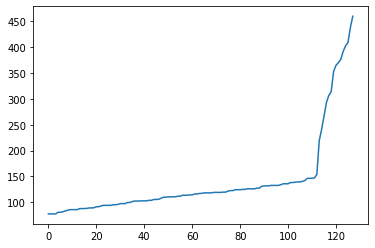

In [87]:
plt.plot(np.sort(np.sqrt(hera_bls_long[:,0]**2+hera_bls_long[:,1]**2)))


In [12]:
sky = np.real(obs.convolve_map(stacked_sky,None,None))


ValueError: shapes (7119,1500) and (2500,) not aligned: 1500 (dim 1) != 2500 (dim 0)

In [ ]:
npix = len(obs.observable_coordinates())

#making separate arrays of theta and phi for data vis
x = obs.observable_coordinates()[:,1] #phi
y = obs.observable_coordinates()[:,0]#theta


print(len(x))
print(len(y))
print(len(sky))
df = pd.DataFrame.from_dict(np.array([x,y,sky]).T)

df.columns = ['phi','theta','temp']

pivotted_obs= df.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax,cbar_kws={'label': 'Flux (K)'})
ax.set_title('HERA 128', y = 1.04)


plt.show()

1500
1500
2700


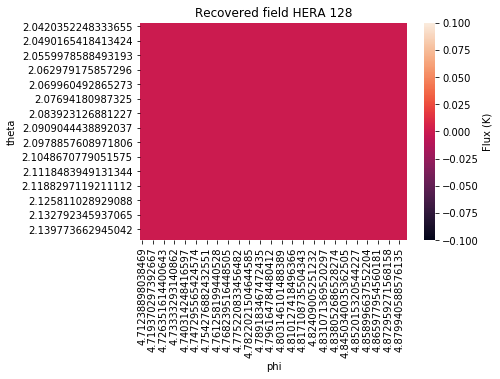

In [29]:
x = obs0.observable_coordinates()[:,1] #phi
y = obs0.observable_coordinates()[:,0]#theta


print(len(x))
print(len(y))
print(len(sky))
df = pd.DataFrame.from_dict(np.array([x,y,np.zeros(1500)]).T)

df.columns = ['phi','theta','temp']

pivotted_obs= df.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax,cbar_kws={'label': 'Flux (K)'})
ax.set_title('Recovered field HERA 128', y = 1.04)


plt.show()

In [738]:
pivotted_obs.shape

(30, 50)

[ 0.  4.  6. 12.  8. 16. 18. 24. 12. 36. 22. 32. 36. 32. 40. 38. 44. 36.
 60. 46. 60. 50. 62. 60. 78. 60. 68. 69. 72. 56. 56. 56. 49. 40. 38. 20.
 22. 20. 16. 12.  8.  4.  1.  0.  0.  0.  0.  0.  0.  0.]
7000
4.313828150691252e-15


/Users/hannahfronenberg/Documents/GitHub/Hannah-Msc/HERA Hack/pspec.py:162: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.5, 1.0, 'A mangled (feature scaled) power spectrum')

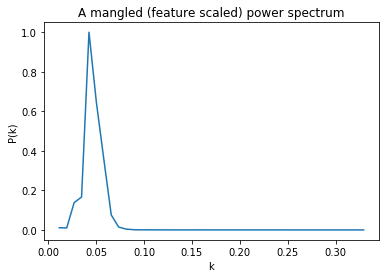

In [195]:
#recovered pspec

array = np.asarray(pivotted_obs)

power_spec = pspec.Power_Spectrum(pivotted_obs,70,100,50,False) #100 Mpc by 100Mpc --> have to scale fft I think 
pk = power_spec.compute_2D_pspec()

k = pk[0]
p_k = (pk[1] - min(pk[1])*np.ones(len(pk[1])))/(max(pk[1])-min(pk[1]))

print(min(pk[1]))
plt.plot(k,p_k) 
plt.xlabel('k')
plt.ylabel('P(k)')
plt.title('A mangled (feature scaled) power spectrum') 

#Power is really low... 

# Visibility issue 


In [34]:
make_uni_5 = make_universe.universe(ps,row_npix = 30,col_npix = 50, Lx = 80, Ly = 100, mean = 5)#100 Mpc by 100Mpc
make_uni_0 = make_universe.universe(ps,row_npix = 30,col_npix = 50, Lx = 80, Ly = 100, mean = 0)#100 Mpc by 100Mpc

universe_0 = make_uni_0.make_2D_universe()
uni_5 = universe_0 + (np.zeros((universe.shape[0],universe.shape[1]))+5)


stacked_sky_0 = np.hstack(universe_0.T)
stacked_5 = np.hstack(uni_5.T)

sky_5 = np.real(obs5.convolve_map(stacked_5,None,None))
sky_0 = np.real(obs0.convolve_map(stacked_sky_0,None,None))



Text(0.5, 1, '0.01 Mean Vis weighting')

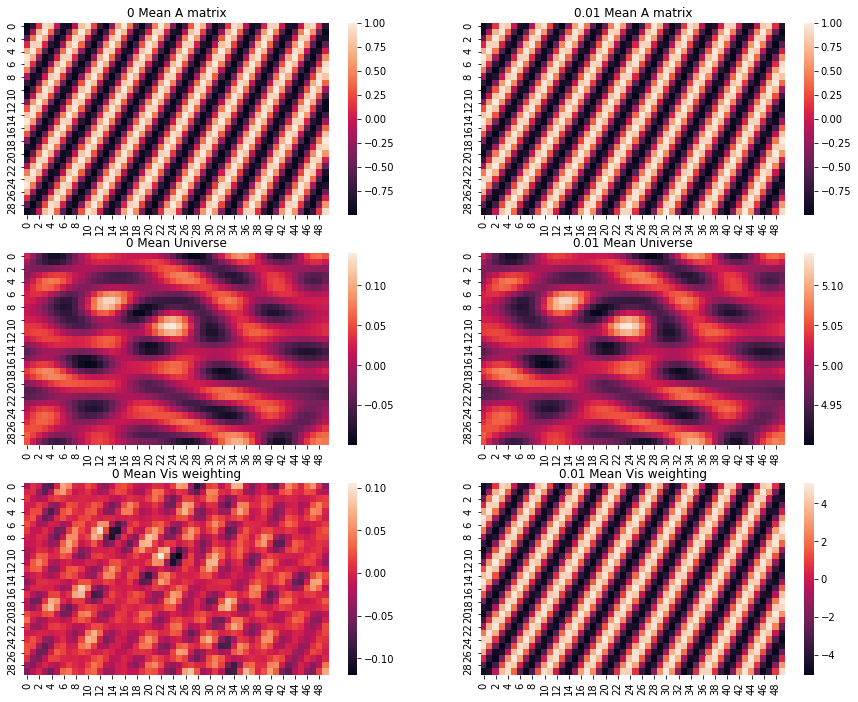

In [35]:
minus = 0
fig, ax = plt.subplots(3,2, figsize = (15,12))

uni_mean = uni_5 - minus*np.ones((30,50))
stacked_mean = stacked_5 - minus*np.ones(obs0.Npix)
obs0.Amat.shape

b=600
vis_0 = obs0.Amat[b]*stacked_sky_0
A_0 = obs0.Amat[b]
#np.reshape(universe_0,(30,50))*np.real(np.reshape(obs0.Amat[b],(50,30))).T
vis_5 = (obs5.Amat[b]*(stacked_mean))
A_5 = obs5.Amat[b]
#np.reshape(uni_5,(30,50))*np.real(np.reshape(obs5.Amat[b],(50,30))).T

#All os the components of the A matrix are the same, it's the weighting of elements of Amat that 
#is the issue --> but the relative weighting should be the same... 

sns.heatmap(np.real(np.reshape(A_0,(50,30)).T), ax = ax[0,0])
ax[0,0].set_title('0 Mean A matrix')
sns.heatmap(np.real(np.reshape(A_5,(50,30)).T), ax = ax[0,1])
ax[0,1].set_title('0.01 Mean A matrix')

sns.heatmap(universe_0, ax = ax[1,0])
ax[1,0].set_title('0 Mean Universe')
sns.heatmap(uni_mean, ax = ax[1,1])
ax[1,1].set_title('0.01 Mean Universe')

sns.heatmap(np.real(np.reshape(vis_0,(50,30)).T), ax = ax[2,0])
ax[2,0].set_title('0 Mean Vis weighting')
sns.heatmap(np.real(np.reshape(vis_5,(50,30)).T), ax = ax[2,1])
ax[2,1].set_title('0.01 Mean Vis weighting')

(30, 50)

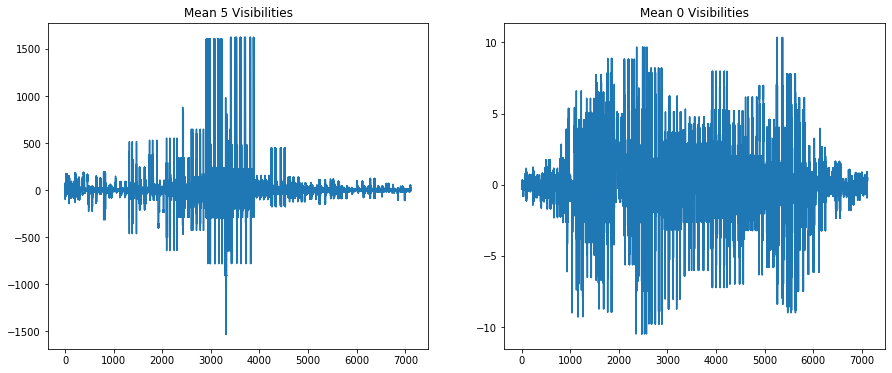

In [374]:

vis_mean_0 = obs0.Adotx
vis_mean_5 = obs5.Adotx

fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(np.real(vis_mean_5))
ax[0].set_title('Mean 5 Visibilities')
ax[1].plot(np.real(vis_mean_0))
ax[1].set_title('Mean 0 Visibilities')

# Go through and pick out those tall bois. 
bad_bls_5 = []
for i in range(obs5.Adotx.shape[0]):
    if obs5.Adotx[i] >= 750:
        bad_bls_5.append(i)
    

In [253]:
len(bad_bls_5)

137

In [254]:
nbls = np.arange(0,len(bad_bls_5),1)
print(len(nbls))
#pick out all the mad visibilities and their basline mabnitudes
bad_vis_5 = []
mag_bad_bls_5 = []

for i in range(len(bad_bls_5)):
    bad_vis_5.append(obs5.Adotx[bad_bls_5[i]])
    x = np.sqrt((obs5.bl_times[bad_bls_5[i],0]**2)+(obs5.bl_times[bad_bls_5[i],1]**2)+(obs5.bl_times[bad_bls_5[i],2]**2))
    mag_bad_bls_5.append(x)

137


In [273]:
bad_vis_0= []
mag_bad_bls_0 = []

for i in range(len(bad_bls_5)):
    bad_vis_0.append(obs0.Adotx[bad_bls_5[i]])
    x = np.sqrt((obs0.bl_times[bad_bls_5[i],0]**2)+(obs0.bl_times[bad_bls_5[i],1]**2)+(obs0.bl_times[bad_bls_5[i],2]**2))
    mag_bad_bls_0.append(x)

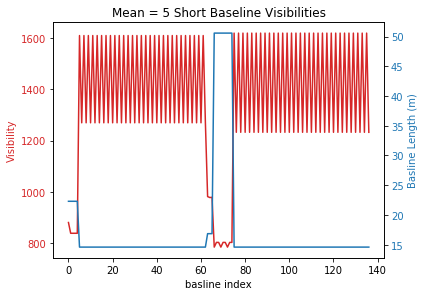

In [277]:


fig, ax1 = plt.subplots()


color = 'tab:red'
ax1.set_xlabel('basline index')
ax1.set_ylabel('Visibility', color=color)
ax1.plot(nbls,np.abs(np.real(bad_vis_5)), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Basline Length (m)', color=color)  # we already handled the x-label with ax1
ax2.plot(nbls,mag_bad_bls_5, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Mean = 5 Short Baseline Visibilities')# otherwise the right y-label is slightly clipped
plt.show()

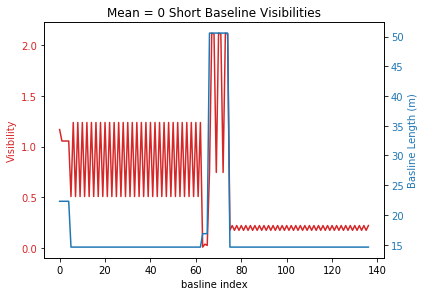

In [276]:


fig, ax1 = plt.subplots()


color = 'tab:red'
ax1.set_xlabel('basline index')
ax1.set_ylabel('Visibility', color=color)
ax1.plot(nbls,np.abs(np.real(bad_vis_0)), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Basline Length (m)', color=color)  # we already handled the x-label with ax1
ax2.plot(nbls,mag_bad_bls_0, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Mean = 0 Short Baseline Visibilities')# otherwise the right y-label is slightly clipped
plt.show()

I think what the problem is, is that you are really picking out the contribution from the uniform shifting. 
The only time your visibilites would mirror(I mean copy, not like a chiral image) the A matrix is when your
sky is uniform. The mean itself is not the problem, it is the uniformity.

Need to make sure that flucutations about the mean can "hold their own". 


In [66]:
uniform_sky = np.repeat(5,1500)
uniform_sky = np.real(obs.convolve_map(uniform_sky,None,None))

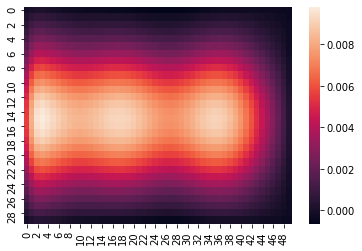

In [67]:
sns.heatmap(np.reshape(uniform_sky,(50,30)).T) #BINGO WE'RE PLOTTING A UNIFORM SKY! 

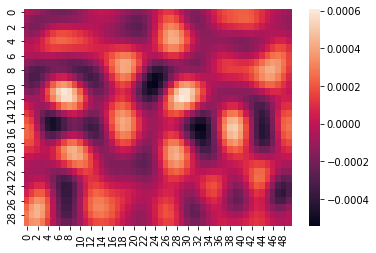

In [405]:
delta = sky-uniform_sky 

sns.heatmap(np.reshape(delta,(50,30)).T) #if you subtract off the mean you recover the sky fluctuations. 

In [278]:
#Non-coplanar baslines could be the issue, 
#so now I want to see where in the array these bad baslines are located.
#Apparently they should be near the edges. 

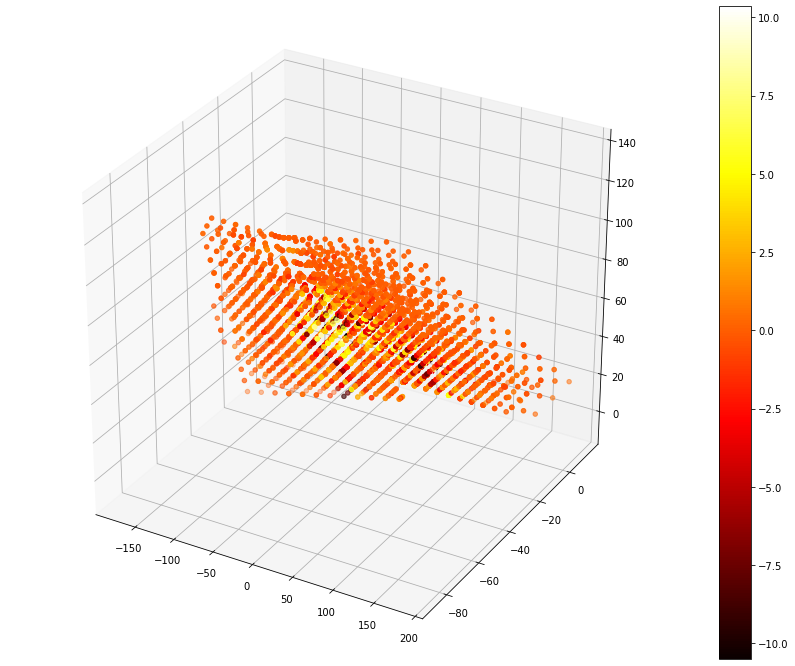

In [369]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (15,12))

ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(obs0.bl_times[:,0], obs0.bl_times[:,1], obs0.bl_times[:,2], c=obs0.Adotx, cmap=plt.hot())
fig.colorbar(img)
plt.show()

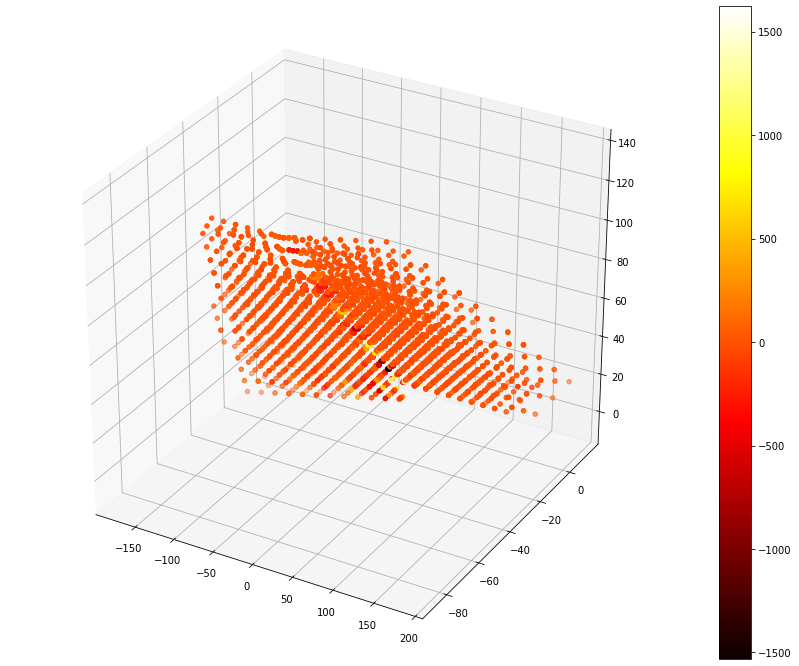

In [371]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (15,12))
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(obs5.bl_times[:,0], obs5.bl_times[:,1], obs5.bl_times[:,2], c=obs5.Adotx, cmap=plt.hot())
fig.colorbar(img)
plt.show()

# Mangling Matrix 

In [13]:
#Mdotx = np.dot((np.real(obs.Mmat)),stacked_sky)

obs.compute_M(None,None)

<AxesSubplot:>

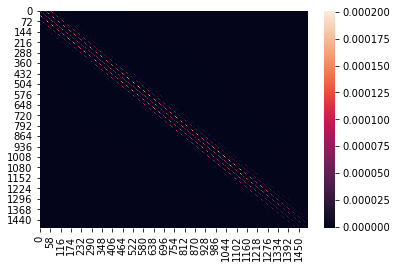

In [14]:
sns.heatmap(np.real(obs.Mmat))

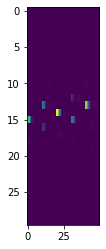

In [600]:
#reshape in config space
M_1 = obs.Mmat[720]
M_1 = np.reshape(M_1, (30,50))


plt.imshow(np.real(M_1), aspect=5)

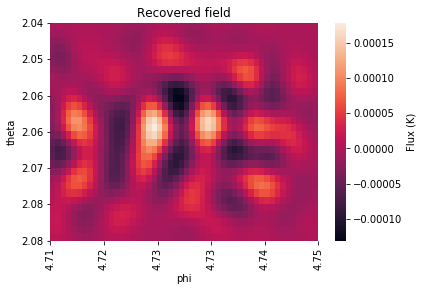

In [59]:
npix = len(obs.observable_coordinates())
Mdotx = np.dot(obs.Mmat,stacked_sky)
#making separate arrays of theta and phi for data vis
x = np.zeros(npix)
y = np.zeros_like(x)

for i in range(len(obs.observable_coordinates())):
    x[i]= obs.observable_coordinates()[i,1] #phi
    y[i] = obs.observable_coordinates()[i,0]#theta

df = pd.DataFrame.from_dict(np.array([x,y,np.real(Mdotx)]).T)
df.columns = ['phi','theta','temp']



pivotted_obs= df.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax,cbar_kws={'label': 'Flux (K)'})
ax.set_title('Recovered field', y = 1.04)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]

ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.show()

#same as other recovered map that's good 

In [65]:
if isinstance(k, np.ndarray):
    print('yes')
else:
    print('no')
    
if callable(ps):
    print('yes')
else:
    print('no')

yes
yes


In [57]:
type(k[1])

numpy.float64

# Window function


$W(k,k') = \tilde{M}(k,-k')$  (I believe based on my calcs)

In [30]:
M = obs.Mmat


M_bar = []
npix = M.shape[0]
#first 2d fft 
k_col = 0
k_row = 0 
for i in range(npix): 
    m = M[i]
    m = np.reshape(m,(50,30))#this stacks rows of m so m[30]=m_reshape[1,0]
    m_bar = np.fft.fft2(m)# I am confused as to whether i should use fftshift because these ks are already in order
    if i == 1:
        k_col = np.fft.fftfreq(m_bar.shape[0])
        k_row = np.fft.fftfreq(m_bar.shape[1])
        print(k_col.shape)
        print(k_row.shape)
    else:
        pass
    m_bar = np.reshape(m_bar,(1500,)) # gotta do a lil zip-a-dee-doo-da here to match k and FFTs 
    M_bar.append(m_bar)
    
#Now I will sort the rows of M_tilde according to k 

k = []
#you MUST loop through the row first then the col in order to match m reshape
for i in range(len(k_row)): 
    for j in range(len(k_col)):
        k.append(np.sqrt(k_col[j]**2 + k_row[i]**2))

k = np.asarray(k)

#so now, it should be the case that if i reshape k, k[30] = k_reshape[1,0] --> can be a test

k_reshape = np.reshape(k,(50,30)) #make sure same reshape as m in the loop.

print(k[30],k_reshape[1,0])#YAY SHE IS FOLDED RIGHT 
    
Mbar = np.asarray(M_bar)
oh 
M_tilde = []

#second 2d fft

for i in range(npix): 
    m = Mbar[:,i]
    m = np.reshape(m,(50,30))#this stacks rows of m so m[50]=m[1,0]
    m_bar = np.fft.fft2(m)
    m_bar = np.reshape(m_bar,(1500,))
    M_tilde.append(m_bar)
   
    
#Now I will sort the rows of M_tilde according to k along both the row and column axis. 

s=np.argsort(k)
J = np.take(M_tilde,s,axis = 0) #axis 0 reorders rows
print(J)
M_tilde_sorted = np.take(J,s,axis =1)#axis 1 sorts the columns into the right order
M_tilde_sorted = np.asarray(M_tilde_sorted).T #why is this transpose here??? I think because of reshaping but check
k_sorted = np.sort(k) # now you can sort k's 
M_tilde_sorted.shape

(50,)
(30,)
0.4 0.4
[[ 1.17751721e+00+1.73472348e-18j  4.46816312e-02+2.25281545e-02j
   7.28257223e-02+2.00499349e-02j ...  1.03715173e-02-8.94760941e-03j
   1.27098379e-02-9.79283943e-03j  1.49740448e-01-7.27185324e-02j]
 [-1.15915997e+00+3.91252876e-03j -7.88247345e-02-4.78717883e-03j
  -4.13190827e-02-1.68486319e-03j ...  5.94450162e-03-4.18780285e-03j
   1.33687058e-01-6.79583626e-02j -4.15579909e-01+2.13287562e-01j]
 [-2.32513993e-03+2.34980093e-03j -8.76658102e-04+4.23669083e-04j
  -6.36844516e-04+2.96522738e-04j ... -2.32903003e-03+5.79661381e-03j
  -2.89468264e-03+2.93139237e-03j -2.64538129e-03-1.46144629e-03j]
 ...
 [ 1.20844967e-04-3.43119544e-05j  2.71068035e-05-6.74256971e-05j
   3.03776859e-05-2.02152859e-05j ... -2.92099566e-05+3.11536005e-05j
  -2.78845163e-05+1.75930393e-05j -2.08745971e-05-1.31608826e-05j]
 [ 1.78114151e-04+3.19439365e-05j  4.97629707e-05-9.52600914e-05j
   4.35838400e-05-2.04382959e-05j ... -5.08516849e-05+3.49247031e-05j
  -5.17173148e-05+2.0147669

(1500, 1500)

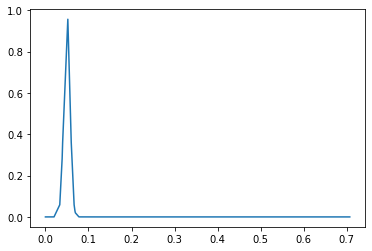

In [27]:

        
# plt.imshow(np.reshape(k , (50,30)))


plt.plot(k_sorted, ps(k_sorted))

In [31]:
Wmat = np.zeros_like(obs.Mmat)

for i in range(Wmat.shape[0]):
    for j in range(Wmat.shape[1]):
        Wmat[i,j] = M_tilde_sorted[i,-j]

w = ((np.conj(Wmat)))*(Wmat)
print(w)
print(w.shape)

#Careful! is this index negation a linear transformation?
#if not, does the sorting need to come after this step?

# window = []

# #normalization
# for i in range(Wmat.shape[0]):
#     norm = 1/(np.sum(w[i])) #find the normalization factor which is 1/sum of the row
#     window.append(w[i]*norm)

# window = np.asarray(window)
# #NORMALIZE EACH ROW OF window AFTER BINNING I THINK!!!



[[1.38654677e+00+0.j 2.13778843e-08+0.j 3.27450660e-08+0.j ...
  6.42058461e-06+0.j 1.09278401e-05+0.j 1.34366715e+00+0.j]
 [2.50396591e-03+0.j 7.39806672e-09+0.j 1.15508383e-08+0.j ...
  7.77794629e-07+0.j 9.48024920e-07+0.j 6.23625585e-03+0.j]
 [1.25406662e-05+0.j 4.19860879e-10+0.j 5.32357094e-10+0.j ...
  5.02999986e-07+0.j 8.41546578e-08+0.j 7.06465633e-07+0.j]
 ...
 [4.29207540e-08+0.j 4.43494302e-10+0.j 5.56491632e-10+0.j ...
  1.36755919e-09+0.j 1.36401428e-09+0.j 2.06841742e-08+0.j]
 [1.03242138e-07+0.j 6.37114902e-10+0.j 8.63441515e-10+0.j ...
  7.91597407e-10+0.j 1.23789048e-09+0.j 8.27444795e-08+0.j]
 [6.34140063e-08+0.j 5.69526574e-10+0.j 7.35509011e-10+0.j ...
  8.39761501e-10+0.j 1.32210112e-09+0.j 3.83746560e-08+0.j]]
(1500, 1500)


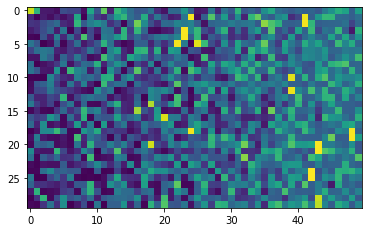

In [32]:
plt.imshow(np.log(np.real(np.reshape(w[900],(50,30)).T)))

Text(0.5, 1.0, 'Fourier Transform')

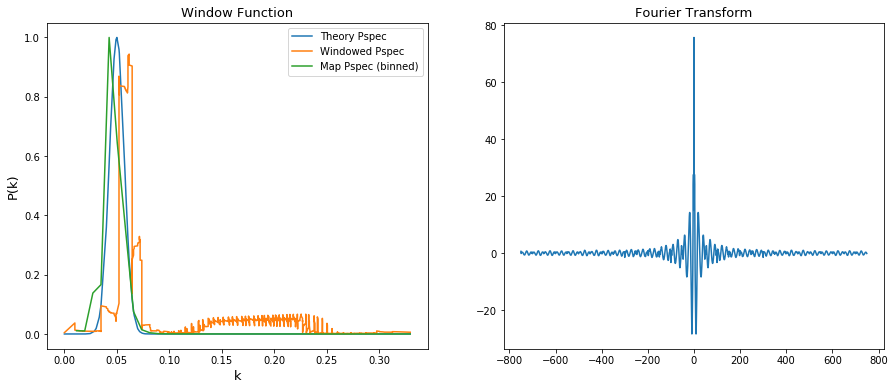

In [196]:




P = np.ones((1500,))
P_hat = np.dot(window, make_uni.theory_spec)

fig, ax = plt.subplots(1,2, figsize = (15,6))
ax[0].plot(make_uni.ksorted,make_uni.theory_spec, label = 'Theory Pspec')
ax[0].plot(make_uni.ksorted,np.real(P_hat), label = "Windowed Pspec")
ax[0].plot(k,p_k, label = 'Map Pspec (binned)') 
ax[0].set_ylabel('P(k)', fontsize = 13)
ax[0].set_xlabel('k', fontsize = 13)
ax[0].legend()

bins = np.arange(-750,750,1)
fft_window = np.fft.fftshift(np.fft.fft(P_hat))

ax[1].plot(bins,np.real(fft_window))

ax[0].set_title('Window Function', fontsize = 13)
ax[1].set_title('Fourier Transform', fontsize = 13)






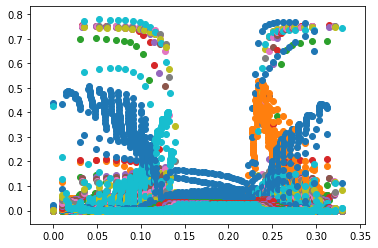

In [197]:
for i in range(window.shape[0]):
    plt.scatter(make_uni.ksorted, np.real(window[:,i]))

# Naive Binning of W and P

Here I'm just going to be using the no.hist bins k bins. Ideally your bins would be finer where there is structure in your power spectrum and broader where there isn't. This will come next, but the algorithm written here will be general enough to use in the more nuances case.

In [59]:
############ BINNING OF POWER SPECTRUM #############

nbins = 30
hist, bin_edges = np.histogram(k_sorted, bins = nbins)
# k = make_uni.ksorted
# P_k = make_uni.theory_spec

# p_theory_binned = np.zeros(nbins)
# k_central_binned = np.zeros(nbins)

# min_index = 0
# for i in range(len(bin_edges)-1):
#     max_index = np.sum(hist[:i+1])#hist[i] + min_index 
#     min_index = np.sum(hist[:i])
#     ####### bin P values #####
#     a = np.sum(P_k[min_index:max_index]) #sum of P_k values in that bin
#     c = hist[i] #number of P_k values in that bin 
#     p_theory_binned[i] = a/c #compute averate P_k in that bin
    
#     ####### bin k values #####
#     b = np.sum(k[min_index:max_index])
#     k_central_binned[i] = b/c
    
    
print(bin_edges)

[0.         0.02357023 0.04714045 0.07071068 0.0942809  0.11785113
 0.14142136 0.16499158 0.18856181 0.21213203 0.23570226 0.25927249
 0.28284271 0.30641294 0.32998316 0.35355339 0.37712362 0.40069384
 0.42426407 0.44783429 0.47140452 0.49497475 0.51854497 0.5421152
 0.56568542 0.58925565 0.61282588 0.6363961  0.65996633 0.68353656
 0.70710678]


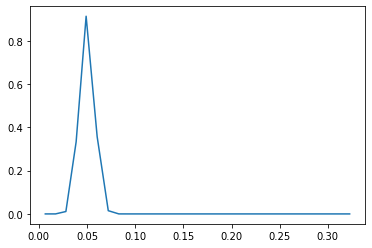

In [134]:
plt.plot(k_central_binned, p_theory_binned) 
### this should be approximately the same as the power spectrum of the universe

[[4.62182275e-01 4.00475598e-08 8.55123546e-07 2.64201712e-05
  1.62603914e-05 1.25920591e-05 1.44756307e-06 2.10519059e-05
  1.06335469e-05 9.87562570e-06 1.46002931e-05 5.03315763e-05
  8.77106893e-05 1.28760859e-05 1.81061126e-04 1.20129710e-04
  1.13123670e-03 3.58644221e-04 1.16763574e-05 3.94693567e-05
  4.82513061e-05 1.40690842e-04 1.23588415e-03 1.95773261e-03
  8.63092659e-05 9.20601895e-05 7.60250027e-04 3.58606084e-04
  2.24804919e-03 2.68740370e-01]
 [8.34661621e-04 1.08060612e-08 1.38343371e-07 1.04578607e-06
  6.33467883e-07 5.80816102e-07 2.29408023e-07 8.21926673e-07
  3.88707702e-07 6.96184477e-07 7.20896416e-07 3.69427669e-06
  7.13400552e-06 1.33154553e-06 1.69833419e-05 4.24340367e-06
  6.73316569e-05 4.36856074e-06 1.32847992e-06 2.77683077e-06
  3.31852041e-06 6.30641916e-06 3.03836488e-05 2.76321189e-05
  1.42091950e-05 1.52803136e-05 3.97113320e-05 5.33428920e-05
  3.17708920e-04 1.24792632e-03]
 [4.18053947e-06 6.60329126e-10 8.67727249e-10 2.43686727e-09
  1.

<ipython-input-36-d2ffe9ebea0d>:47: RuntimeWarning: divide by zero encountered in double_scalars
  norm = 1/(np.sum(W_collapse[i])) #find the normalization factor which is 1/sum of the row
<ipython-input-36-d2ffe9ebea0d>:48: RuntimeWarning: invalid value encountered in multiply
  window.append(W_collapse[i]*norm)


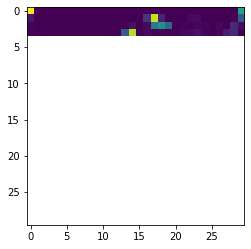

In [36]:
############ BINNING OF W MATRIX ALONG BOTH AXES #########
npix = window.shape[0]

nbins = 30
hist, bin_edges = np.histogram(k_sorted, bins = nbins) #want to use bayesian block bin eventually!!!

W_col_collapse = np.zeros((npix,nbins))

for j in range(npix): # pick a row
    min_index = 0
    for i in range(len(bin_edges)-1):
        max_index = np.sum(hist[:i+1])#hist[i] + min_index 
        min_index = np.sum(hist[:i])
        ####### bin W values #####
        w_real = np.real(w)
        a = np.sum(w_real[j,min_index:max_index]) 
        c = hist[i] #number of P_k values in that bin 
        W_col_collapse[j,i] = a/c #compute averate P_k in that bin--> maybe wrong binning here
        
print(W_col_collapse) # for some reason... this happens to only have values for a 30,30 window... automatically.

# W_collapse = W_col_collapse[:30]

# print(W_collapse.shape)
        
W_collapse = np.zeros((nbins,nbins)) 

for j in range(nbins): # pick a column ## only 30 now!
    min_index = 0
    for i in range(len(bin_edges)-1):
        max_index = np.sum(hist[:i+1])#hist[i] + min_index 
        min_index = np.sum(hist[:i])
        ####### bin W values #####
        w_real = np.real(W_col_collapse)
        a = np.sum(w_real[min_index:max_index,j])
        c = hist[i] #number of P_k values in that bin 
        W_collapse[i,j] = a/c#compute averate P_k in that bin
    

print(W_collapse.shape)
# ###### NORMALIZE #######

window = []

#normalization
for i in range(W_collapse.shape[0]):
    norm = 1/(np.sum(W_collapse[i])) #find the normalization factor which is 1/sum of the row
    window.append(W_collapse[i]*norm)

window = np.asarray(window)

plt.imshow(window)
print(W_collapse)


No handles with labels found to put in legend.


[0.         0.02357023 0.04714045 0.07071068 0.0942809  0.11785113
 0.14142136 0.16499158 0.18856181 0.21213203 0.23570226 0.25927249
 0.28284271 0.30641294 0.32998316 0.35355339 0.37712362 0.40069384
 0.42426407 0.44783429 0.47140452 0.49497475 0.51854497 0.5421152
 0.56568542 0.58925565 0.61282588 0.6363961  0.65996633 0.68353656
 0.70710678]


NameError: name 'bine_edges' is not defined

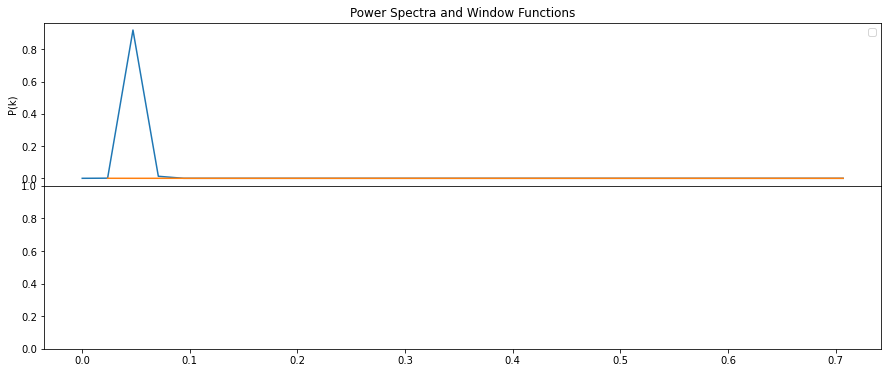

In [37]:
P_estimate = np.dot(W_collapse,np.ones(30))

# print(window.shape)
# print(p_theory_binned.shape)
# print(P_estimate.shape)
# print(k_central_binned.shape)

print(bin_edges)

fig, ax = plt.subplots(2, 1, figsize = (15,6),sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0})

# ax[0].plot(k_central_binned, p_theory_binned,label = 'True binned psepc')
# ax[0].plot(k_central_binned,P_estimate, label = 'Estimated Pspec')
ax[0].plot(bin_edges,ps(bin_edges))
ax[0].plot(bin_edges[1:],np.dot(W_collapse,ps(bin_edges[1:])))
ax[0].set_xlabel('k')
ax[0].set_ylabel('P(k)')
ax[0].legend()
ax[0].set_title('Power Spectra and Window Functions')
for i in range(nbins): 
    ax[1].plot(bine_edges,window[i],c = 'k')
ax[1].set_xlabel('k')


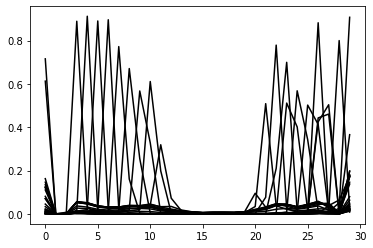

In [171]:
for i in range(nbins):
    

11
[  3   8  12  20  22  31  37  36  38  56  54  66  64  72  80  84  84  84
 106  91  96  84  73  58  48  30  32  18   8   5]
[0.         0.01097565 0.0219513  0.03292694 0.04390259 0.05487824
 0.06585389 0.07682954 0.08780519 0.09878083 0.10975648 0.12073213
 0.13170778 0.14268343 0.15365907 0.16463472 0.17561037 0.18658602
 0.19756167 0.20853732 0.21951296 0.23048861 0.24146426 0.25243991
 0.26341556 0.2743912  0.28536685 0.2963425  0.30731815 0.3182938
 0.32926944]
[0.         0.01       0.01       0.01428571 0.01428571 0.01743794
 0.01743794 0.01743794 0.01743794 0.02       0.02       0.02457807
 0.02457807 0.02457807 0.02457807 0.02857143 0.02857143 0.03
 0.03       0.03027089 0.03027089 0.03027089 0.03027089 0.03322772
 0.03322772 0.03322772 0.03322772 0.03487587 0.03487587 0.03487587
 0.03487587 0.04       0.04       0.04142857 0.04142857 0.04142857
 0.04142857 0.04247448 0.04247448 0.04247448 0.04247448 0.04285714
 0.04285714 0.04400835 0.04400835 0.04400835 0.04400835 0.047294

AssertionError: 

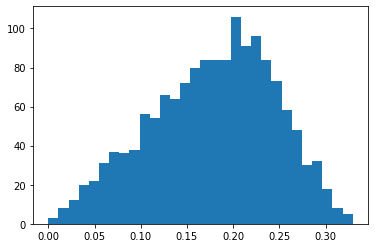

In [211]:
#Thoery spec: make_uni.ksorted,make_uni.theory_spec

#bin_edges = np.histogram_bin_edges(make_uni.ksorted, bins = 30)

hist, bin_edges = np.histogram(make_uni.ksorted, bins = 30)
print(np.sum(hist[:2]))
print(hist)
print(bin_edges)
print(make_uni.ksorted[:50])
plt.hist(make_uni.ksorted, bins = 30)
assert False
p_theory_binned = np.zeros(50)


nk = npix//30

for i in range(len(bin_edges)-1):
    a = 0
    c = 0
    half_bin = (bin_edges[i+1]-bin_edges[i])//2
    for j in range(nk):
        a += np.real(P_sim[np.int(bin_edges[i])+j])
        c += 1.0
    p_tb[i] = (a/c)
    #k.append((bin_edges[i]+half_bin)*0.1)
    
# 2. bin W along both axes 

#(1) collapse columns --> result should be 1500 x 30 matrix

W_col_collapse = np.zeros((1500,30))

for h in range(npix): #pick a row  
    for i in range(len(bin_edges)-1):
        a = 0 #for components
        c = 0 #for holding the number of elements per bin
        half_bin = (bin_edges[i+1]-bin_edges[i])//2
        for j in range(nk):
            a += np.real(abs_square[h,np.int(bin_edges[i])+j])
            c += 1.0
        W_col_collapse[h,i] = a/c
        
W_collapse = np.zeros((30,30))

for h in range(30): #pick a column  
    for i in range(len(bin_edges)-1):
        a = 0 #for components
        c = 0 #for holding the number of elements per bin
        half_bin = (bin_edges[i+1]-bin_edges[i])//2
        for j in range(nk):
            a += np.real(abs_square[np.int(bin_edges[i])+j,h])
            c += 1.0
        W_collapse[i,h] = a/c
      

In [141]:
row_sum = []
for i in range(window.shape[0]):
    row_sum.append(np.sum(window[i]))

/Users/hannahfronenberg/anaconda2/envs/p37workshop/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


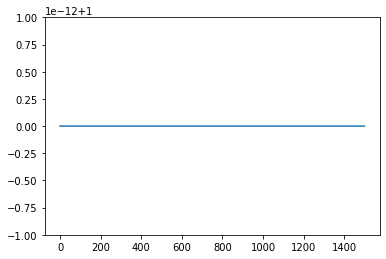

In [142]:
plt.plot(row_sum)

In [310]:
Wmat = np.zeros_like(obs.Mmat)

M_tilde = np.fft.fftshift(np.fft.fft2(obs.Mmat))

M_tilde_1 = np.reshape(M_tilde[1],(30,50))

for i in range(Wmat.shape[0]):
    for j in range(Wmat.shape[1]):
        Wmat[i,j] = M_tilde[i,-j]
        

window = ((np.conj(Wmat)))*(Wmat)
#Q: is W always square? i think yes because I think M is always square 




/Users/hannahfronenberg/anaconda2/envs/p37workshop/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


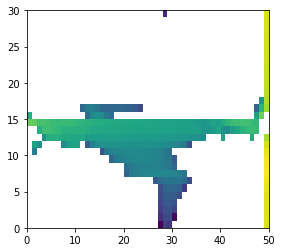

In [268]:
plt.imshow(np.log(np.real(M_tilde_1)),extent=[0,50,0,30],  aspect=1.5)


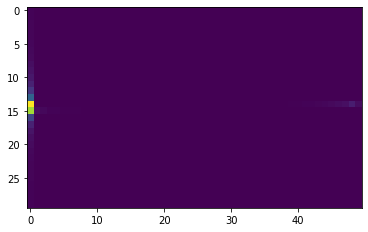

In [246]:


w_0 = np.reshape(np.real(window[:,750]), (30,50))

# for i in range(npix-1):
#     w_0 += window[i+1]

plt.imshow(w_0)

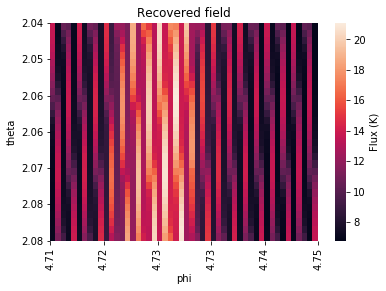

In [210]:
npix = len(obs.observable_coordinates())
#making separate arrays of theta and phi for data vis
x = np.zeros(npix)
y = np.zeros_like(x)

for i in range(len(obs.observable_coordinates())):
    x[i]= obs.observable_coordinates()[i,1] #phi
    y[i] = obs.observable_coordinates()[i,0]#theta

df = pd.DataFrame.from_dict(np.array([x,y,np.log(np.real(w_0))]).T)
df.columns = ['phi','theta','temp']



pivotted_obs= df.pivot('theta','phi','temp')

ax = plt.axes()

sns.heatmap(pivotted_obs,ax=ax,cbar_kws={'label': 'Flux (K)'})
ax.set_title('Recovered field', y = 1.04)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
xlabels = [item.get_text() for item in ax.get_xticklabels()]
ylabels = [item.get_text() for item in ax.get_yticklabels()]

ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

plt.show()



In [115]:
a = [1,1,1,1,2,2,2,2,3,3,3,3]

a = np.reshape(a,(3,4))
print(a.T)

[[1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]]


# Binning $P_{bin}$

50
(2.770089088605187e-08+0j)


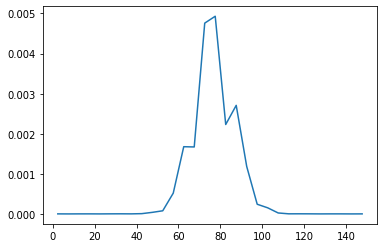

In [182]:
x = np.linspace(0,10,npix)
pix = np.linspace(0,npix,1500)

nk = npix//30
print(nk)


abs_square = ((np.conj(Wmat)))*(Wmat)
x_xs = np.dot(abs_square,ps(x))

delta = 5

P_sim = x_xs/(((5*npix)**2)*((2*np.pi)**3))
print(P_sim[2])
hist, bin_edges = np.histogram(pix, bins = 30)


k = []
p_binned = []



for i in range(len(bin_edges)-1):
    a = 0
    c = 0
    half_bin = (bin_edges[i+1]-bin_edges[i])//2
    for j in range(nk):
#         print(bin_edges[i])
#         print(j)
#         print(P_sim[np.int(bin_edges[i])+j])
        a += P_sim[np.int(bin_edges[i])+j]
        c += 1.0
    p_binned.append(a/c)
    k.append((bin_edges[i]+half_bin)*0.1)

# somewhere I need to include binning, I think. 

plt.plot(k,np.real(p_binned))


In [165]:
len(k)

30

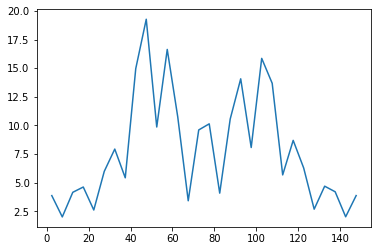

In [184]:
p_sim = np.dot(W_collapse,p_tb)

plt.plot(k,p_sim)

TypeError: unsupported operand type(s) for -: 'list' and 'int'

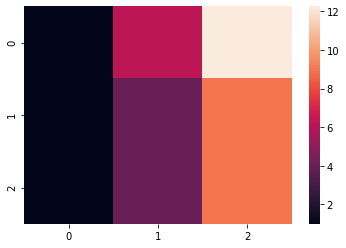

In [50]:
a = np.array([[1,2.5,3.5],[1,2,3],[1,2,3]])
sns.heatmap(a**2)

a = a.T
a_stack = np.stack(a, axis = 0)


In [90]:
freq = np.arange(0,9,1)
freq

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [91]:
np.fft.fftshift(freq)

array([5, 6, 7, 8, 0, 1, 2, 3, 4])

In [98]:
iff = np.fft.ifftshift(freq)

iff = np.delete(iff,0)

iff = np.append(iff,[4])

iff

array([5, 6, 7, 8, 0, 1, 2, 3, 4])

In [72]:
Y = ["a", "b", "c", "d", "e", "f", "g", "h", "i"]
X = [ 0,   1,   1,    0,   1,   2,   2,   0,   1]
B = zip(Y,X)

print(tuple(B))

Z = [x for _,x in sorted(zip(Y,X))]
print(Z.reshape)  # ["a", "d", "h", "b", "c", "e", "i", "f", "g"]


(('a', 0), ('b', 1), ('c', 1), ('d', 0), ('e', 1), ('f', 2), ('g', 2), ('h', 0), ('i', 1))


AttributeError: 'list' object has no attribute 'reshape'

In [21]:
#sorting test 

X = np.array([3,2,1]) #this is akin to my k's, its the array which respect to which we want to sort. 
print(X)

Y = np.array([['A','B', 'C'], ['B','A', 'C'],['C','B','A']])
print(Y)


#1. for loop zipping 

#2. argsort()


s=np.argsort(X)
J = np.take(Y,s,axis = 0) #axis 0 reorders rows
print(J)
G = np.take(J,s,axis =1)#axis 1 sorts the columns into the right order
print(G)

[3 2 1]
[['A' 'B' 'C']
 ['B' 'A' 'C']
 ['C' 'B' 'A']]
[['C' 'B' 'A']
 ['B' 'A' 'C']
 ['A' 'B' 'C']]
[['A' 'B' 'C']
 ['C' 'A' 'B']
 ['C' 'B' 'A']]
